__Background__:

I was inspired by one of Internet Historian video, [The Engoodening of No Man's Sky](https://www.youtube.com/watch?v=O5BJVO3PDeQ&t=1s), particularly this following segment:

"Then he starts breaking that (all the feedback of the game from various sources) down into datasets: people who haven't bought the game, people who have bought it and played it for a hundred hours, people who have returned it, etc. Then he starts compiling those complaints into usable data, focusing on the people with the most sincere experience of the game. Then he starts making a big list of all the things that need adding and prioritize them."

This workflow was really interesting to me, because it is applicable in many cases, especially in industry. So here it is, my first attempt on exploring the field of NLP. 

__Goals__:

Here, I am going to analyze the reviews on Steam games, a platform I mostly use to play video games. The exact goals of this project are:
- Analyze what words are associated with good reviews (reviewer recommended the game)
- Predicting whether a reviewer recommended the game or not based on the review

Obviously, this project is not going to be as grandeur as what Sean Murray did, but I would like to have a hands-on experience on sentiment analysis in general.

So please, enjoy!

In [130]:
# Import standard libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

# COLOR = 'black'
# mpl.rcParams['text.color'] = 'black'
# mpl.rcParams['axes.labelcolor'] = COLOR
# mpl.rcParams['xtick.color'] = COLOR
# mpl.rcParams['ytick.color'] = COLOR

Steam reviews dataset: https://www.kaggle.com/datasets/luthfim/steam-reviews-dataset

In [2]:
# Load data
data = pd.read_csv("steam_reviews_new.csv")

# Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   date_posted             20000 non-null  object
 1   funny                   20000 non-null  int64 
 2   helpful                 20000 non-null  int64 
 3   hour_played             20000 non-null  int64 
 4   is_early_access_review  20000 non-null  bool  
 5   recommendation          20000 non-null  object
 6   review                  19931 non-null  object
 7   title                   20000 non-null  object
dtypes: bool(1), int64(3), object(4)
memory usage: 1.1+ MB


In [3]:
# Check data content
data.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2017-04-02,0,0,0,True,Not Recommended,Pretty much same controls and buggy mess as al...,PLAYERUNKNOWN'S BATTLEGROUNDS
1,2018-06-18,0,0,48,False,Not Recommended,game cant even find stone,Rust
2,2018-08-16,0,0,81,False,Not Recommended,EVERY DRAGON NEED A BLOOD BAR !!!!!!!! I spend...,MONSTER HUNTER: WORLD
3,2015-09-30,0,0,164,False,Not Recommended,Great game. Just not into the whole open world...,Grand Theft Auto V
4,2019-01-19,1,7,30,False,Not Recommended,People compare this game to dark souls but it ...,MONSTER HUNTER: WORLD


Columns:
- `date_posted`: The date a review is posted
- `funny`: How many other player think the review is funny
- `helpful`: How many other player think the review is helpful
- `hour_played`: How many hour a reviewer play the game before make a review
- `recommendation`: Whether the reviewer recommended the game or not
- `review`: The text of user review
- `title`: The game's title that's being reviewed

In [4]:
# Check top rows
data.head(5)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2017-04-02,0,0,0,True,Not Recommended,Pretty much same controls and buggy mess as al...,PLAYERUNKNOWN'S BATTLEGROUNDS
1,2018-06-18,0,0,48,False,Not Recommended,game cant even find stone,Rust
2,2018-08-16,0,0,81,False,Not Recommended,EVERY DRAGON NEED A BLOOD BAR !!!!!!!! I spend...,MONSTER HUNTER: WORLD
3,2015-09-30,0,0,164,False,Not Recommended,Great game. Just not into the whole open world...,Grand Theft Auto V
4,2019-01-19,1,7,30,False,Not Recommended,People compare this game to dark souls but it ...,MONSTER HUNTER: WORLD


# 1. Preprocessing

From the data info above, we can already notice that there are missing values in `review`. Since our work is going to be heavily relying on this column, we have to clean it from these missing values. In addition, we also need to check for duplicated values following the standard data cleaning procedure.

In [5]:
data[data['review'].isna()]

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
922,2018-02-17,0,0,50,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
1141,2018-02-05,0,0,16,False,Not Recommended,NaN,Grand Theft Auto V
1260,2017-09-16,0,0,502,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
1456,2017-09-30,0,0,148,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
1515,2017-09-29,0,0,0,True,Not Recommended,NaN,Rust
...,...,...,...,...,...,...,...,...
18122,2017-11-22,0,0,671,False,Recommended,NaN,Rocket League®
18794,2017-08-09,0,0,302,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS
19344,2015-05-04,0,0,16,False,Recommended,NaN,Grand Theft Auto V
19676,2018-02-19,0,0,63,False,Not Recommended,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS


In [6]:
data.isna().sum()

date_posted                0
funny                      0
helpful                    0
hour_played                0
is_early_access_review     0
recommendation             0
review                    69
title                      0
dtype: int64

There are only 69 rows with missing reviews, and that is less than 0.5% of the whole dataset. However, let's also explore this a bit. What games are mostly missing reviews?

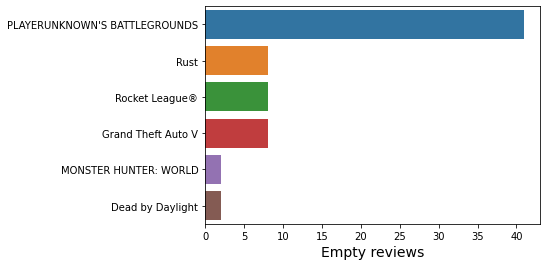

In [7]:
# Get rows with missing reviews
data_nan = data[data['review'].isna()]

# Make a bar plot
missing_title = data_nan['title'].value_counts()
sns.barplot(x=missing_title.values,y=missing_title.index)
plt.xlabel('Empty reviews',fontsize=14)

plt.show()

The missing reviews come mostly from the popular games such as PUBG and GTA V. This is expected since they have very large player base, and so more reviews on these games are bound to be useless (such as empty!).

In [8]:
# Drop rows with missing reviews
data.dropna(inplace=True)

# Sanity check
data.isna().sum()

date_posted               0
funny                     0
helpful                   0
hour_played               0
is_early_access_review    0
recommendation            0
review                    0
title                     0
dtype: int64

Next, let's check whether our dataset contains duplicated rows.

In [9]:
data.duplicated().sum()

0

It seems that there are no duplicated rows. But are there duplicated reviews?

In [10]:
data.duplicated(subset='review').sum()

1323

There are 1323 duplicated reviews! Let's check out what these reviews say.

In [11]:
data[data.duplicated(subset='review',keep=False)].sample(10)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
10520,2017-08-25,0,0,745,True,Not Recommended,it sucks,Rust
14249,2017-01-31,0,0,346,False,Recommended,very good,Dead by Daylight
10497,2017-11-14,0,0,54,True,Recommended,Not bad,PLAYERUNKNOWN'S BATTLEGROUNDS
16170,2018-02-02,0,0,211,False,Recommended,Great game love it!,PLAYERUNKNOWN'S BATTLEGROUNDS
2084,2018-09-26,0,0,87,False,Recommended,&lt 3,PLAYERUNKNOWN'S BATTLEGROUNDS
8665,2016-11-23,0,0,518,False,Recommended,Fun with friends,Grand Theft Auto V
13684,2018-11-22,0,0,212,False,Recommended,Good,PLAYERUNKNOWN'S BATTLEGROUNDS
13152,2017-06-22,0,0,96,False,Not Recommended,Rip mods,Grand Theft Auto V
8770,2014-04-07,0,0,35,True,Recommended,Best Game Ever,Rust
12907,2016-11-24,0,0,63,False,Recommended,Great game!,Grand Theft Auto V


Most of them are very short reviews such as 'good' or 'amazing'. These reviews are still important for our classification task, so we will not drop them.

There is also a date column `date_posted` in the dataset. Let's convert this into datetime type.

In [12]:
# Convert to datetime
data['date_posted'] = pd.to_datetime(data['date_posted'])

Last, let's create a column called `recommendation_int`, where 'Recommended' records are labeled as 1's and the 'Not Recommended' records are labeled 0's.

In [13]:
# Create integer form of recommendation
# 1 if recommended, 0 if not
data['recommendation_int'] = (data['recommendation']=='Recommended').astype(int)

data.sample(5,random_state=1806)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,recommendation_int
6588,2017-12-20,1,4,10,True,Not Recommended,Overpriced Overhyped. Generic. A free to play ...,PLAYERUNKNOWN'S BATTLEGROUNDS,0
12881,2018-02-23,0,0,130,False,Not Recommended,Update ruined sound for game cant hear anythin...,PLAYERUNKNOWN'S BATTLEGROUNDS,0
2907,2017-06-30,0,0,1253,False,Recommended,If you're looking for a fast paced car game wi...,Rocket League®,1
11757,2017-10-05,0,0,1206,False,Recommended,Short review Best game I have ever played. The...,Rocket League®,1
16070,2017-04-04,0,0,11,False,Recommended,Fantastic game absolutely love it but it has p...,Grand Theft Auto V,1


# 2. EDA

### a) Categorical and date columns

First, let's check how many games are recommended vs not recommended.

,recommendation
Recommended,70.267423
Not Recommended,29.732577


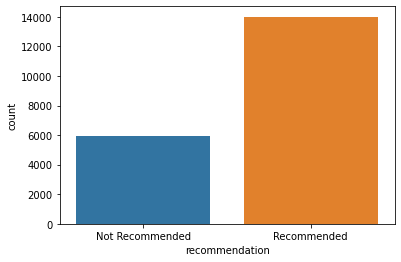

In [14]:
# Count plot of recommendation
sns.countplot(x='recommendation',data=data)

# Count in percentage
pd.DataFrame(data['recommendation'].value_counts(normalize=True)*100)

This dataset is biased towards positive reviews, where positive reviews are more than twice as many as the negative ones.

Let's check the top 10 most reviewed games and the top 10 games by hours played.

Text(0, 0.5, 'Title')

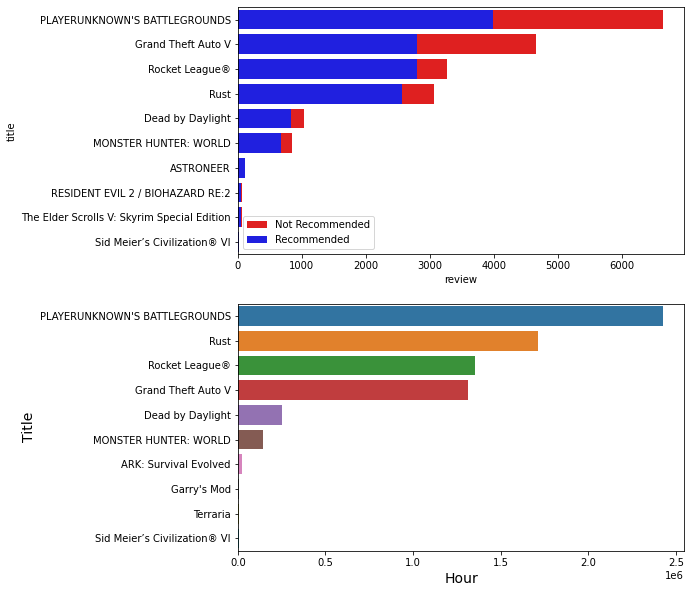

<Figure size 1800x1440 with 0 Axes>

In [15]:
# Make figure and axes objects
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,10))

# Pick just top 10 games
top10_game_review = data['title'].value_counts().head(10)
data_top10 = data[data['title'].isin(top10_game_review.index)]
# Review count for each game
reviews_count = data_top10.groupby(['title'])['review'].count().sort_values(ascending=False)
reviews_count = reviews_count.reset_index()

# Barplot for most reviewed games (divided based on recommendation)
# Plot the total reviews (positive + negative)
plt.figure(figsize=(25,20))
sns.barplot(y=reviews_count['title'], x=reviews_count['review'], data=reviews_count,
            color="r",ax=ax[0],label='Not Recommended')
# Plot the positive reviews on top of the total
reviews_count_pos = data_top10.groupby(['title', 'recommendation'])['review'].count().sort_values(ascending=False)
reviews_count_pos = reviews_count_pos.reset_index()
reviews_count_pos = reviews_count_pos[reviews_count_pos['recommendation'] == 'Recommended']
sns.barplot(y=reviews_count_pos['title'], x=reviews_count_pos['review'], data=reviews_count_pos,
            color="b",ax=ax[0],label='Recommended')

ax[0].legend()

# Barplot for most played games
top10_game_hour = data.groupby('title').agg(hour=('hour_played','sum')).sort_values(by='hour',ascending=False).head(10)
sns.barplot(y=top10_game_hour.index,x=top10_game_hour.hour,ax=ax[1])
ax[1].set_xlabel('Hour',fontsize=14)
ax[1].set_ylabel('Title',fontsize=14)

So the most reviewed games are more or less consistent with the most played games. And we can also see that among the top games, PUBG seems to have the most mixed reviews.

Let's check how many reviews are posted each day, and see the trend when the official PC version of the games were released, and also when Steam sales occurred.

Text(0, 0.5, 'Review count')

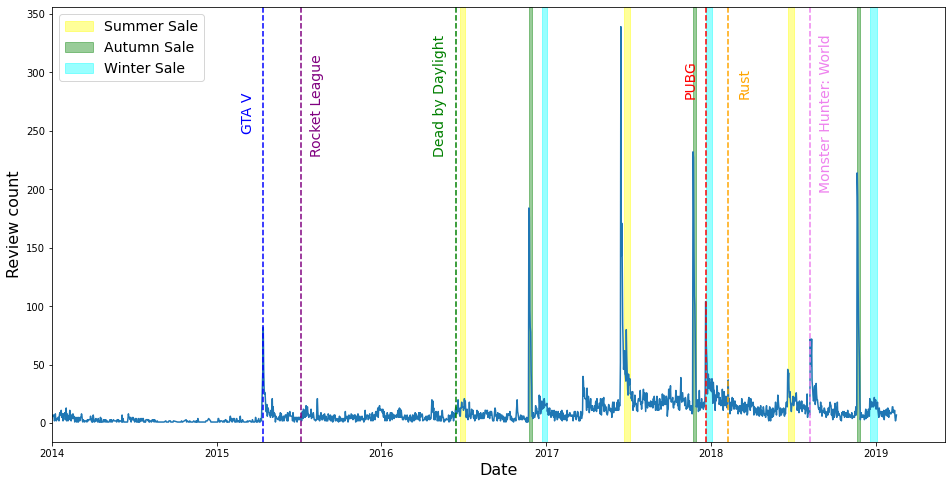

In [16]:
# Count reviews based on date posted
review_date = data.groupby(by='date_posted').agg(count=('date_posted','count'))
date = review_date.index
count = review_date.values

# Dates when the top 6 games were released (PC official release)
date_gtav = np.datetime64('2015-04-14')
date_rocket = np.datetime64('2015-07-07')
date_dbd = np.datetime64('2016-06-14')
date_pubg = np.datetime64('2017-12-21')
date_rust = np.datetime64('2018-02-08')
date_monhun = np.datetime64('2018-08-09')

# Create figure
plt.figure(figsize=(16,8))

# Plot total review each day
plt.plot(date,count)

# Plot vertical lines indicating PC release dates
plt.axvline(x=date_gtav,ls='--',color='blue')
plt.axvline(x=date_rocket,ls='--',color='purple')
plt.axvline(x=date_dbd,ls='--',color='green')
plt.axvline(x=date_pubg,ls='--',color='red')
plt.axvline(x=date_rust,ls='--',color='orange')
plt.axvline(x=date_monhun,ls='--',color='violet')

# Plot text
plt.text(date_gtav-50,250,'GTA V',fontsize=14,rotation='vertical',color='blue')
plt.text(date_rocket+20,230,'Rocket League',fontsize=14,rotation='vertical',color='purple')
plt.text(date_dbd-50,230,'Dead by Daylight',fontsize=14,rotation='vertical',color='green')
plt.text(date_pubg-50,280,'PUBG',fontsize=14,rotation='vertical',color='red')
plt.text(date_rust+20,280,'Rust',fontsize=14,rotation='vertical',color='orange')
plt.text(date_monhun+20,200,'Monster Hunter: World',fontsize=14,rotation='vertical',color='violet')

# Steam sales
# Summer sale 2016
plt.axvspan(np.datetime64('2016-06-23'), np.datetime64('2016-07-04'), alpha=0.4, color='yellow',label='Summer Sale')
# Autumn sale 2016
plt.axvspan(np.datetime64('2016-11-23'), np.datetime64('2016-11-29'), alpha=0.4, color='green',label='Autumn Sale')
# Winter sale 2016
plt.axvspan(np.datetime64('2016-12-22'), np.datetime64('2017-01-02'), alpha=0.4, color='cyan',label='Winter Sale')
# Summer sale 2017
plt.axvspan(np.datetime64('2017-06-22'), np.datetime64('2017-07-05'), alpha=0.4, color='yellow')
# Autumn sale 2017
plt.axvspan(np.datetime64('2017-11-22'), np.datetime64('2017-11-28'), alpha=0.4, color='green')
# Winter sale 2017
plt.axvspan(np.datetime64('2017-12-21'), np.datetime64('2018-01-04'), alpha=0.4, color='cyan')
# Summer sale 2018
plt.axvspan(np.datetime64('2018-06-21'), np.datetime64('2018-07-05'), alpha=0.4, color='yellow')
# Autumn sale 2018
plt.axvspan(np.datetime64('2018-11-21'), np.datetime64('2018-11-27'), alpha=0.4, color='green')
# Winter sale 2018
plt.axvspan(np.datetime64('2018-12-20'), np.datetime64('2019-01-03'), alpha=0.4, color='cyan')

# Limit the graph for clarity
plt.xlim(left=np.datetime64('2014-01-01'))

# Legend, axis labels, ticks
plt.legend(fontsize=14)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Review count',fontsize=16)

Now, let's see the reviews for each of these top 6 games by date, the official release dates, and the Steam sales.

(735050.0, 737091.0)

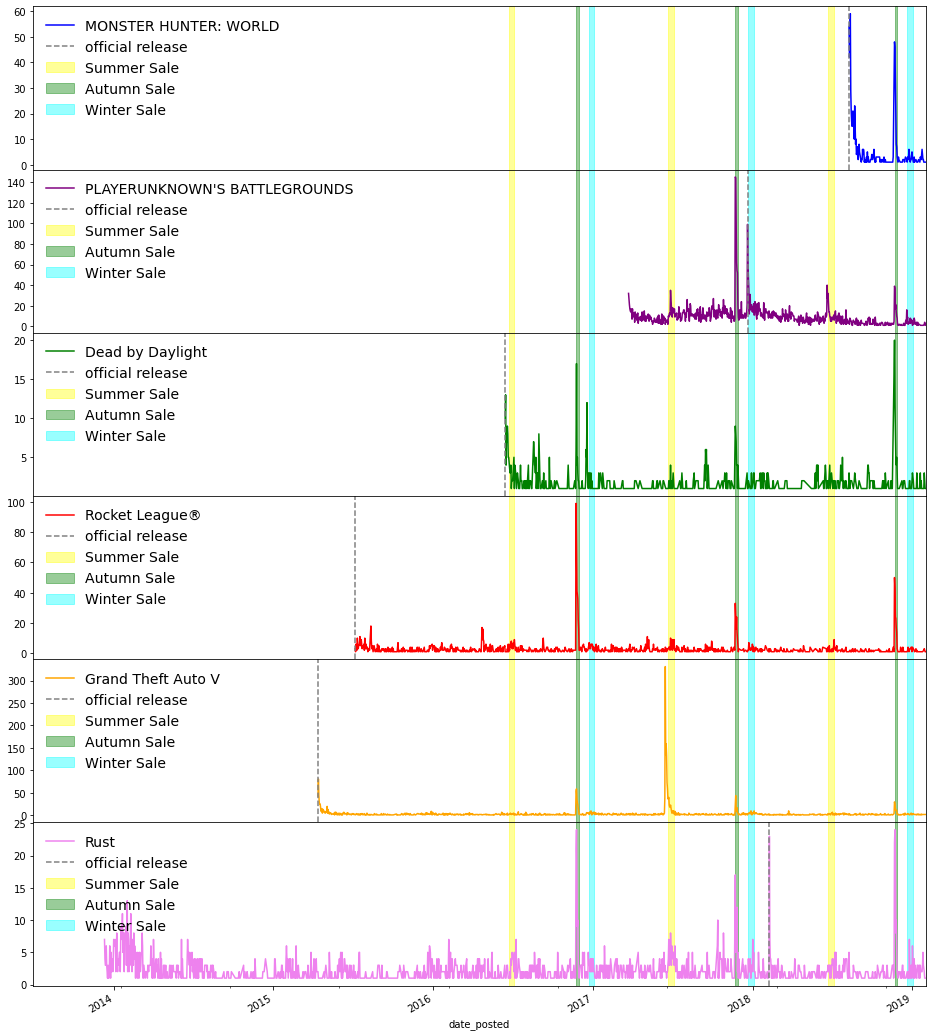

In [17]:
# Top 6 game (sorted by early release date)
top6_game = ['MONSTER HUNTER: WORLD',"PLAYERUNKNOWN'S BATTLEGROUNDS"
             ,'Dead by Daylight','Rocket League®','Grand Theft Auto V', 'Rust']

# Create figure and axis objects
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6,ncols=1,sharex=True,figsize=(16,20))

# Color for the plot
color_list = ['blue','purple','green','red','orange','violet']

# Plot review count
for i, ax in enumerate(fig.axes):
    data[data['title']==top6_game[i]].groupby('date_posted')['review'].count().plot(ax=ax,label=top6_game[i],color=color_list[i])
    ax.legend()

# Plot vertical lines indicating release dates
kwargs_vline = {'ls':'--','color':'grey','label':'official release'}
ax1.axvline(x=date_monhun,**kwargs_vline)
ax2.axvline(x=date_pubg,**kwargs_vline)
ax3.axvline(x=date_dbd,**kwargs_vline)
ax4.axvline(x=date_rocket,**kwargs_vline)
ax5.axvline(x=date_gtav,**kwargs_vline)
ax6.axvline(x=date_rust,**kwargs_vline)

# Plot steam sales (summer and winter)
for ax in fig.axes:
    # Summer sale 2016
    ax.axvspan(np.datetime64('2016-06-23'), np.datetime64('2016-07-04'), alpha=0.4, color='yellow',label='Summer Sale')
    # Autumn sale 2016
    ax.axvspan(np.datetime64('2016-11-23'), np.datetime64('2016-11-29'), alpha=0.4, color='green',label='Autumn Sale')
    # Winter sale 2016
    ax.axvspan(np.datetime64('2016-12-22'), np.datetime64('2017-01-02'), alpha=0.4, color='cyan',label='Winter Sale')
    # Summer sale 2017
    ax.axvspan(np.datetime64('2017-06-22'), np.datetime64('2017-07-05'), alpha=0.4, color='yellow')
    # Autumn sale 2017
    ax.axvspan(np.datetime64('2017-11-22'), np.datetime64('2017-11-28'), alpha=0.4, color='green')
    # Winter sale 2017
    ax.axvspan(np.datetime64('2017-12-21'), np.datetime64('2018-01-04'), alpha=0.4, color='cyan')
    # Summer sale 2018
    ax.axvspan(np.datetime64('2018-06-21'), np.datetime64('2018-07-05'), alpha=0.4, color='yellow')
    # Autumn sale 2018
    ax.axvspan(np.datetime64('2018-11-21'), np.datetime64('2018-11-27'), alpha=0.4, color='green')
    # Winter sale 2018
    ax.axvspan(np.datetime64('2018-12-20'), np.datetime64('2019-01-03'), alpha=0.4, color='cyan')
    
    ax.legend(loc='upper left',fontsize=14,frameon=False)


plt.subplots_adjust(hspace=0)
plt.xlim(np.datetime64('2013-07-01'),np.datetime64('2019-02-01'))

As seen from the plot above, two of the top 6 games, i.e. PUBG and Rust got reviews before the official release. These are the reviews from people who played the early release version of the games. Let's check how many people played the early version of any of the games in the dataset.

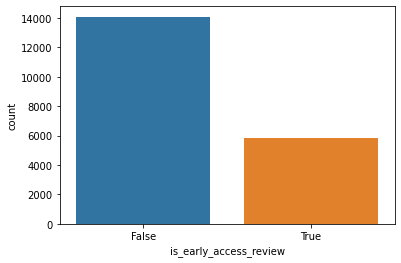

In [18]:
# Check early access count
sns.countplot(x='is_early_access_review',data=data)

As expected, most reviews were posted after the official release of the games.

### b) Numerical columns

Let's create a column containing the length of the review. This is a common step in text analysis, since the length of a text may correlate with the target variable.

In [19]:
# Length of characters in the review
data['length'] = data['review'].apply(len)

Let's check the summary statistics for the numerical columns, i.e. `funny`, `helpful`, `hour_played`, and `length`.

In [20]:
# summary statistics
data[['funny','helpful','hour_played','length']].describe()

,funny,helpful,hour_played,length
count,1.993100e+04,19931.000000,19931.000000,19931.000000
mean,8.619677e+05,1.038934,364.919472,220.169585
std,6.084048e+07,39.642732,541.603964,480.980775
min,0.000000e+00,0.000000,0.000000,1.000000
25%,0.000000e+00,0.000000,63.000000,25.000000
50%,0.000000e+00,0.000000,189.000000,72.000000
75%,0.000000e+00,0.000000,449.000000,211.000000
max,4.294967e+09,4219.000000,10615.000000,8000.000000


We can see that most of the funny and helpful ratings are 0 or empty, up to the 75th percentile, which makes sense since most reviews should go unnoticed by the community. Looking at the maximum values, however, they are surprisingly high. 

The maximum `funny` is 4 billion, which is more than half of the current human population! 

The `helpful` maximum value is around 4000, which still makes sense. 

The `hour_played` maximum value is about 10000 hours. This still makes sense for hardcore gamers or streamers.

The longest review is 8000 characters long, which also makes sense, albeit very long.

So obviously, the maximum value of `funny` doesn't make sense, and we will figure out what the corresponding reviews are as we go.

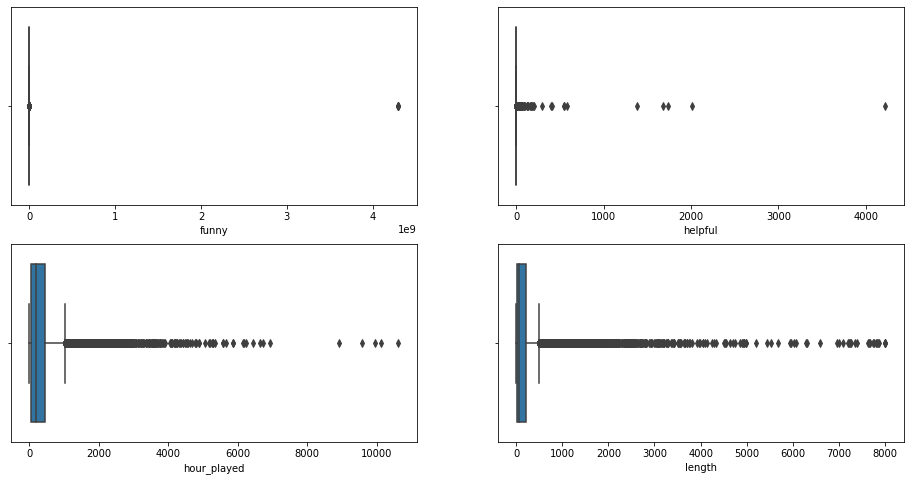

In [21]:
# Check the distribution for these numerical columns
num_cols = ['funny','helpful','hour_played','length']

# Create boxplot
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=col,data=data)

Just to make the visualization easier, I will remove the 0's and the extreme outliers by eye.

In [22]:
# Remove 0's
crit_1 = (data['funny']!=0)&(data['helpful']!=0)&(data['hour_played']!=0)&(data['length']!=0)
# Remove extreme outliers
crit_2 = (data['funny']<600)&(data['helpful']<1000)&(data['hour_played']<8000)&(data['length']<15000)

clean_data = data[crit_1 & crit_2]

clean_data

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,recommendation_int,length
4,2019-01-19,1,7,30,False,Not Recommended,People compare this game to dark souls but it ...,MONSTER HUNTER: WORLD,0,855
5,2017-06-20,1,1,89,False,Not Recommended,KKKK YOUUUUUU,Grand Theft Auto V,0,13
6,2017-10-13,1,2,147,False,Recommended,Product received for free. Mod menu simulator ...,Grand Theft Auto V,1,74
8,2017-12-28,6,16,915,False,Not Recommended,fun game bad community,Rocket League®,0,22
55,2016-07-21,1,2,867,False,Not Recommended,How to crash the game Play it.Don't you dare p...,Grand Theft Auto V,0,248
...,...,...,...,...,...,...,...,...,...,...
19939,2015-10-20,1,1,78,False,Not Recommended,dem..hacker is everywhere...,Grand Theft Auto V,0,28
19969,2016-11-13,1,1,135,False,Recommended,It feels good to be back!,The Elder Scrolls V: Skyrim Special Edition,1,25
19987,2018-04-29,1,1,307,False,Recommended,So they can hack the hackers hacking each othe...,PLAYERUNKNOWN'S BATTLEGROUNDS,1,67
19995,2014-01-03,1,1,15,True,Recommended,i hit man with rock man is kill rip,Rust,1,35


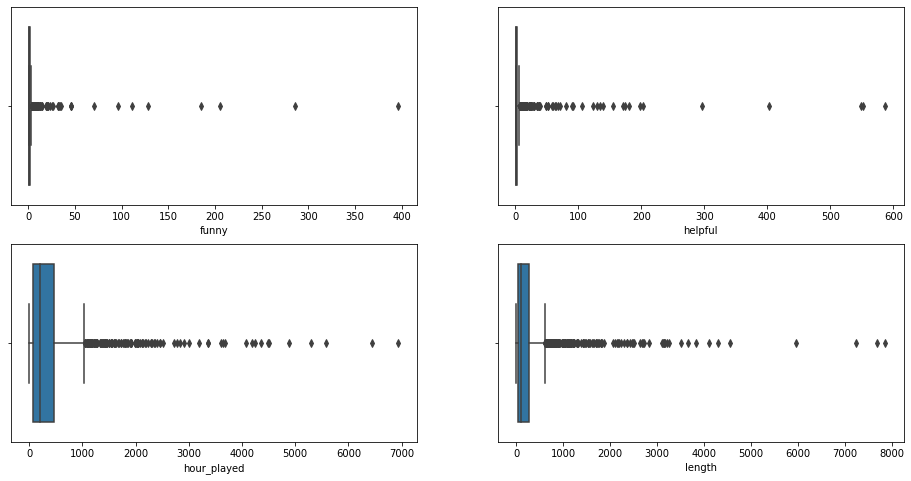

In [23]:
# Create boxplot again
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.boxplot(x=col,data=clean_data)

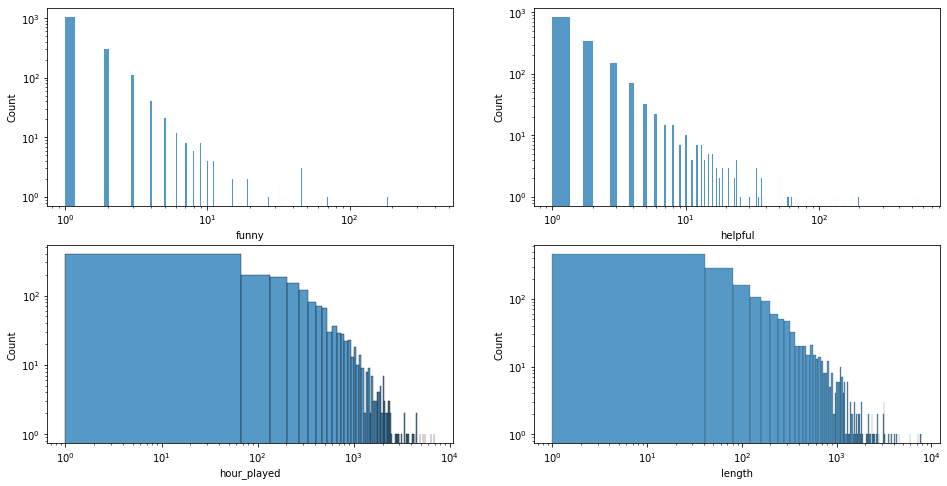

In [24]:
# Histograms
plt.figure(figsize=(16,8))
for i, col in enumerate(num_cols):
    plt.subplot(2,2,i+1)
    sns.histplot(x=col,data=clean_data)
    plt.xscale('log')
    plt.yscale('log')

The length of the reviews, the reactions, and the hours played are monotonically decreasing.

Now, let's check the longest review.

In [25]:
# Maximum characters
print('Longest review: ' + str(data['length'].max()) + ' characters')
# Check the row
data[data['length']==data['length'].max()]

Longest review: 8000 characters


,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,recommendation_int,length
3889,2017-11-24,0,0,51,False,Recommended,thiccccccccccccccccccccccccccccccccccccccccccc...,Grand Theft Auto V,1,8000
8475,2017-09-30,0,0,2526,False,Not Recommended,炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸炸...,PLAYERUNKNOWN'S BATTLEGROUNDS,0,8000


In [26]:
# Print the review
print(data[data['length']==data['length'].max()]['review'].values)

['thiccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

This is obviously just a troll review. But we'll ignore this for now. 

Let's also check the maximum `funny`, `helpful`, and `hour_played`.

In [27]:
# Funniest reviews
data[data['funny']==data['funny'].max()].review.loc[12067]

'If you love being forced onto an island and made to fight to the death? Then PUBG is the game for you...'

In [28]:
# Most helpful reviews
data[data['helpful']==data['helpful'].max()].review.loc[6397]

"4 player split screen? cross platform connectivity? rocket cars? These devs don't around."

In [29]:
# Most played game by hours
data[data['hour_played']==data['hour_played'].max()]

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title,recommendation_int,length
15258,2017-05-12,1,1,10615,False,Recommended,For those of you new to the series Rust puts y...,Rust,1,1120


Let's check if there are any correlation between each pair of the numerical features.

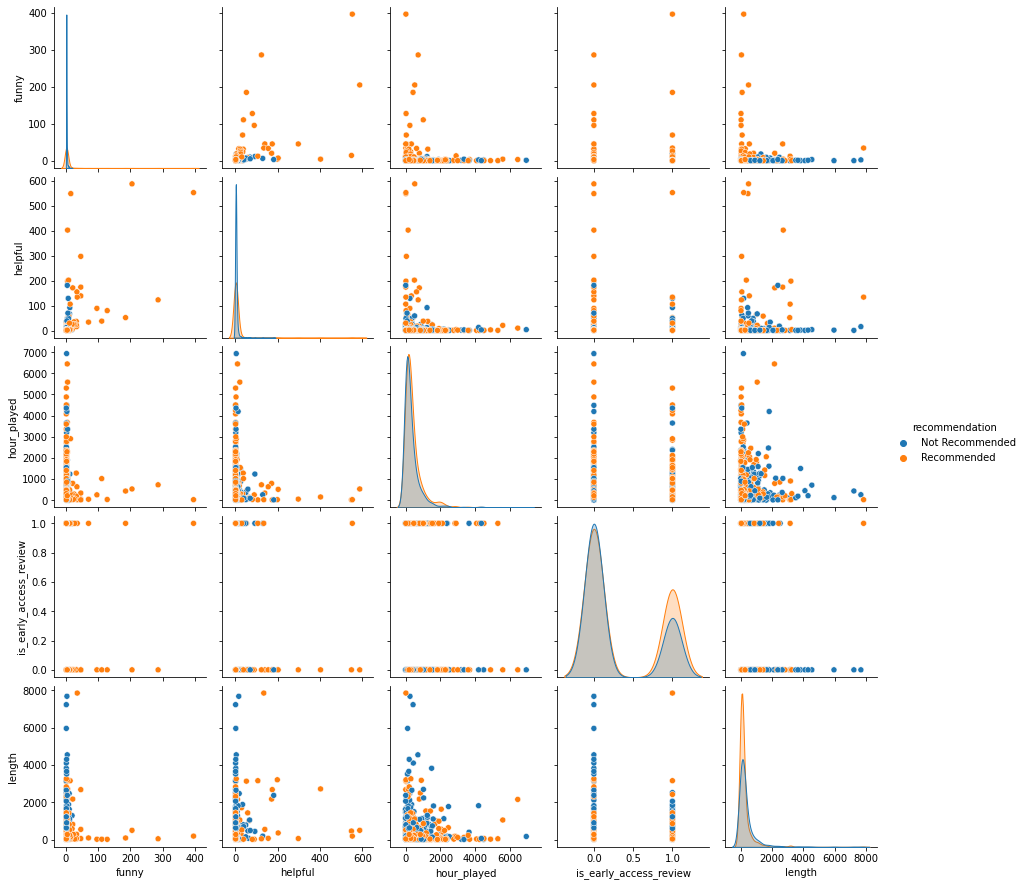

In [30]:
# Create pairplot for numerical columns
sns.pairplot(clean_data.drop('recommendation_int',axis=1),hue='recommendation')

There seems to be no apparent correlation between any of them.

Finally, let's check whether the length of the review correlates with its recommendation status.

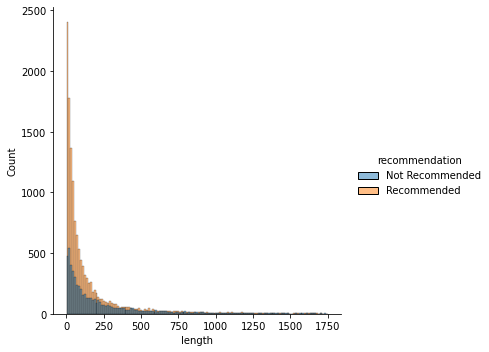

In [31]:
# Check the length of review vs recommendation
df = data[data['length']<1750]

sns.displot(x='length',data=df,hue='recommendation')

There also does not seem to be correlation between the length of the review and the reviewer's recommendation on the game.

### c) Word Cloud

Let's make a word cloud for the entire dataset.

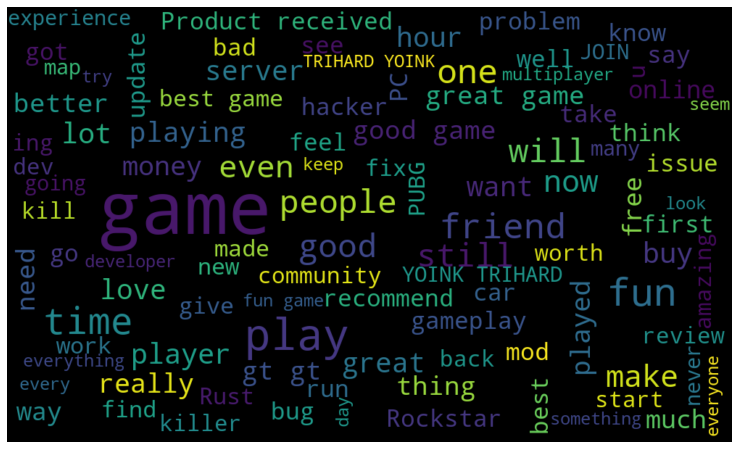

In [32]:
from wordcloud import WordCloud

def create_wordcloud(data,cm):
    txt = ' '.join(rev for rev in data['review'])
    plt.figure(figsize=(15,8))

    wordcloud = WordCloud(
                background_color = 'black',
                max_font_size = 100,
                max_words = 100,
                width = 1000,
                height = 600,
                colormap=cm
                ).generate(txt)


    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    return

create_wordcloud(data,'viridis')

Now, let's make a word cloud for the positive review (recommended games).

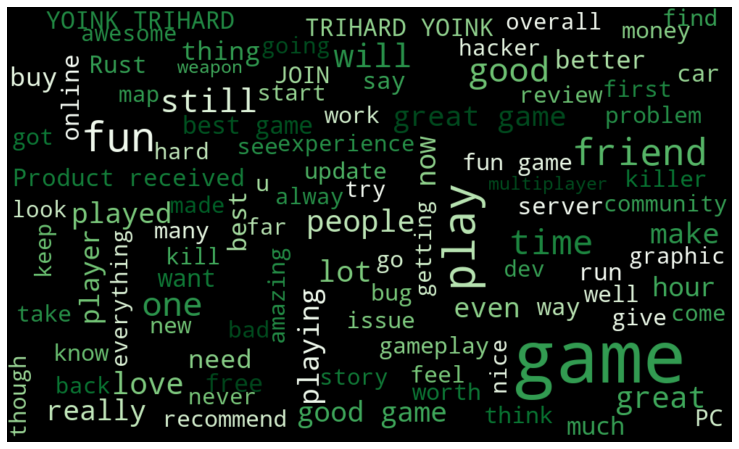

In [33]:
create_wordcloud(data[data['recommendation']=='Recommended'],'Greens')

We can see that the most common words are 'great', 'fun', 'amazing', 'recommend' etc. They all convey positive emotions.

Finally, let's create a word cloud for the negative reviews (not recommended).

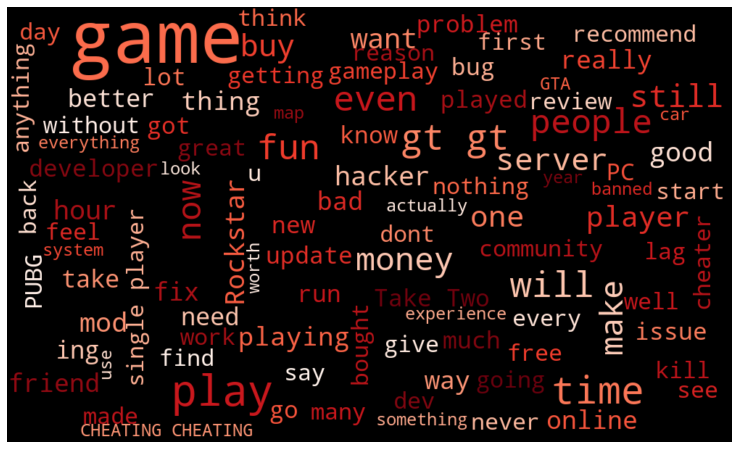

In [34]:
create_wordcloud(data[data['recommendation']=='Not Recommended'],'Reds')

We can see that the most common words are 'cheating', 'bad', 'hacker', 'problem', 'lag' etc. They all convey negative emotions.

# 3. Text Processing

This is where the real work begin. Basically, we want to convert these reviews into something that can be understood by the machine, i.e. numbers. However, we will not be using the entire dataset, because it will take too much time. I will only use reviews posted in the year 2019. For the most part, we will use regular expression and the `nltk` library to process the reviews.

First, we will remove any non alphanumeric characters from the document.

### a. Remove non-alphanumeric characters

In [35]:
# Use regular expression
import re

# Define the function
def remove_symbols(text):
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

### b. Remove Punctuation and Digits and convert to lower case

Punctuations such as ',','.','?','!' and digits such as '1','2','3' are useless in text analysis, so we will remove them. We also convert each alphabetical character to lower case to reduce the number of words, since Python is case-sensitive.

In [36]:
# Use string package to get list of punctuation
import string

# Create a function to remove punctuation
def remove_special_char(text):
    # Remove digits with regular expression
    text = re.sub(r'\d+', '', text)
    
    # Check characters to see if they are in punctuation and remove punctuation
    # Store lowercase character
    nopunc = [char.lower() for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    return nopunc

### c. Remove Stop Words

Stop words such as 'i', 'me', 'my', 'myself', 'we', 'our' appear very often and therefore useless for making predictions. We will use nltk's list of stop words to remove the stop words in our reviews.

In [37]:
from nltk.corpus import stopwords

def remove_stopwords(text):
    # Split the review into words
    text = text.split()
    
    # Check word if it is in nltk's stop word list and remove them
    no_stopword = [word for word in text if word not in (stopwords.words('english'))]
    
    return ' '.join(no_stopword)

### d. Stemming

Words such as 'going', 'went', 'gone' and 'goes' stem from the same word, 'go'. This process of converting words into their base form is called stemming. In text analysis, we do stemming to reduce complexity. We will use Snowball Stemmer for this purpose.

In [38]:
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

def stemming(text):
    stem=[]
    
    snowball_stemmer = SnowballStemmer('english')
    
    word_tokens = word_tokenize(text)
    
    stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
    
    stem=' '.join(stemmed_word)
    
    return stem

### e. Remove Irrelevant Words

In addition to the stop words provided in the nltk library, there are also words that appear frequently that convey no sentiment, such as 'game' and 'get'. These words are obtained from inspecting the wordcloud and they are removed iteratively from the document (all done manually!).

In [39]:
def remove_irrelevant_words(text):
    
    irrelevant_words = ['game','get','gt','got','play']
    
    word_tokens = word_tokenize(text)
    
    cleaned_text = [word for word in word_tokens if word not in irrelevant_words]
    
    cleaned_text = ' '.join(cleaned_text)
    
    return cleaned_text

We have done the main steps in text processing. Now, let's apply these functions to our document.

In [40]:
# Clean the reviews by combining the previous functions
def clean_text(data):
    data_clean = data.copy()
    data_clean['review'] = data_clean['review'].apply(remove_symbols)
    data_clean['review'] = data_clean['review'].apply(remove_special_char)
    data_clean['review'] = data_clean['review'].apply(remove_stopwords)
    data_clean['review'] = data_clean['review'].apply(stemming)
    data_clean['review'] = data_clean['review'].apply(remove_irrelevant_words)
    return data_clean

data_clean = clean_text(data)

In [41]:
# Compare the original and cleaned review
print('Original review: \n', data['review'].loc[0] ,'\n')
print('Cleaned review: \n', data_clean['review'].loc[0])

Original review: 
 Pretty much same controls and buggy mess as all the other battle royale games. 

Cleaned review: 
 pretti much control buggi mess battl royal


### e. Word Cloud (Again)

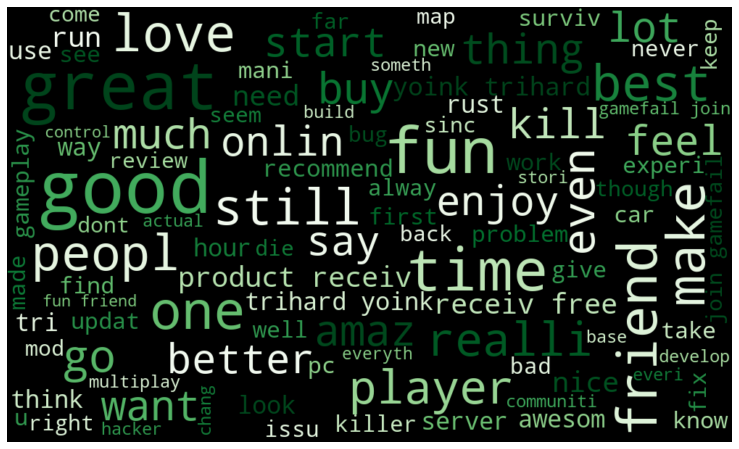

In [42]:
# For positive reviews
create_wordcloud(data_clean[data_clean['recommendation']=='Recommended'],'Greens')

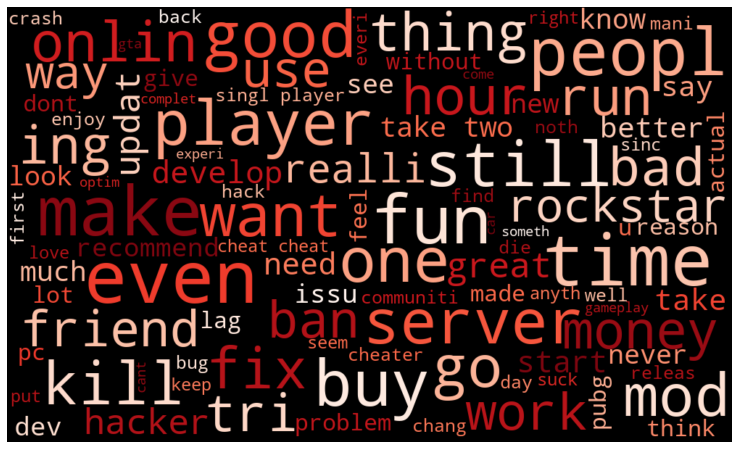

In [43]:
# For negative reviews
create_wordcloud(data_clean[data_clean['recommendation']=='Not Recommended'],'Reds')

In [44]:
from collections import Counter

# Check the most frequent word
review_vis2 = data_clean.copy()
review_vis2['temp_list'] = review_vis2['review'].apply(lambda x:str(x).split())
top = Counter([item for sublist in review_vis2['temp_list'] for item in sublist])
temp = pd.DataFrame(data=[top.keys(),top.values()]).T
temp.columns = ['Common_words','count']
temp.sort_values(by='count',ascending=False).head(10).reset_index(drop=True)

,Common_words,count
0,fun,4079
1,good,3897
2,like,3843
3,time,3145
4,great,2608
5,one,2400
6,player,2387
7,make,2299
8,friend,2279
9,even,2195


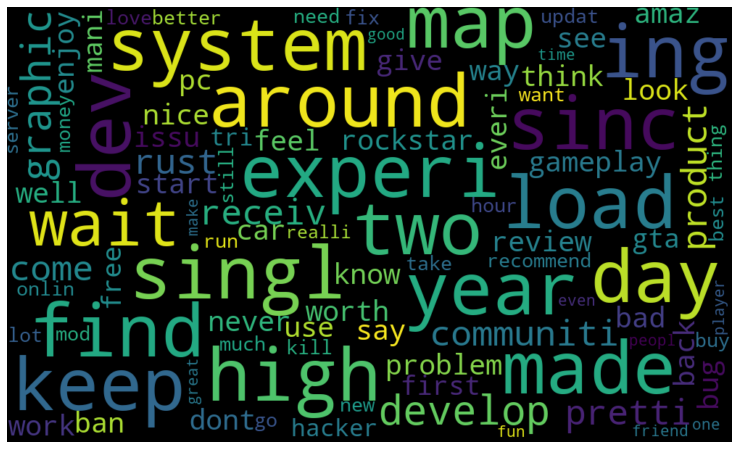

In [45]:
# Word cloud for top words
create_wordcloud(temp.rename(columns={'Common_words':'review'}).sort_values(by='count').tail(100),'viridis')

Therefore 'fun', 'good', and 'like' are the most common words in our document, which is expected since most of the reviews are positive.

# 4. Baseline model: Simple Bag-of-Words/Count Vector

We have cleaned the reviews. Now, it's time to vectorize the reviews and create a model to predict whether a review conveys a positive or a negative sentiment.

In [46]:
# Train-test split
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data_clean, test_size=0.3, random_state=42)

In [47]:
# Import text vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Import classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
# Import pipeline
from sklearn.pipeline import Pipeline
# ROC curve and PR curve
from sklearn.metrics import roc_curve, precision_recall_curve
# Import grid search, randomized search, and stratified folding
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
# Import hyperopt for Bayesian search
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# For model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score,recall_score, precision_score

# Function to print evaluation metric
def model_evaluation(name,y_test,y_pred):
    round_result = 3
    print(f'Model: {name}','\n')
    cm = confusion_matrix(y_test,y_pred)
    print('Confusion matrix: \n', cm,'\n')
    print('Classification report: \n',classification_report(y_test,y_pred))
    print("\n")
    print(f'TN - True Positive: {cm[1,1]}')
    print(f'FP - False Negative: {cm[1,0]}')
    print(f'FN - False Positive: {cm[0,1]}')
    print(f'TP - True Negative: {cm[0,0]}')
    print(f'Accuracy Rate: {round(accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Misclassification Rate: {round(1-accuracy_score(y_test,y_pred),round_result)*100}%')
    print(f'Recall: {round(recall_score(y_test,y_pred),round_result)}')
    print(f'Precision: {round(precision_score(y_test,y_pred),round_result)}')
    print(f'F1-Score: {round(f1_score(y_test,y_pred),round_result)}')
    print(f'ROC-AUC score: {round(roc_auc_score(y_test,y_pred),round_result)}')
    return

# Create a class for the machine learning model
class Model():
    
    def __init__(self,name,df,vectorizer,classifier,fixed_params={},random_state=42,test_size=0.3):
        self.name = name
        self.vectorizer = vectorizer
        self.classifier = classifier
        self.seed = random_state
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_state
        
        # split the data into train and test data by test_size:1-test_size
        self.feature = 'review'
        self.target = 'recommendation_int'
        self.X_train = df[self.feature]
        self.y_train = df[self.target]
        
        # Create a pipeline
        self.pipeline = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
    
    def train_and_evaluate_base(self,k_folds=10):
        
        # Split the training into training-validation (cross-validation)
        skf = StratifiedKFold(n_splits=k_folds)
        X = self.X_train
        y = self.y_train
        
        # Generate list to store score from CV method
        self.cv_accuracy_score = []
        self.cv_roc_auc_score = []
        
        # Iterate over the k-folds and save the scores
        for i, (train, valid) in enumerate(skf.split(X, y)):
            self.pipeline.fit(X.iloc[train], y.iloc[train])
            y_valid_pred = self.pipeline.predict(X.iloc[valid])
            self.cv_accuracy_score.append(accuracy_score(y.iloc[valid],y_valid_pred))
            self.cv_roc_auc_score.append(roc_auc_score(y.iloc[valid],y_valid_pred))
        
        # Print the mean value of the CV results
        print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score)*100,3)}%')
        print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score),3)}')
        
        return
    
    # Perform bayesian search over the hyperparameter space
    # Objective function whose loss we want to minimize
    def objective_func(self,args):
        # Initialize model pipeline
        pipe = self.pipeline
        
        # Model parameters will be set here
        pipe.set_params(**args) 

        # Cross Validation Score
        score = cross_val_score(pipe, self.X_train, self.y_train,scoring='accuracy', cv=5, n_jobs=-1, error_score=0.99)

        # We return 1- score to minimize it
        return {'loss': 1 - np.mean(score), 'status': STATUS_OK}
    
    # Get the best hyperparameters using Bayesian search
    def bayes_search(self,space,max_evals=50):
        
        # Hyperopts Trials() records all the model and run artifacts.
        trials = Trials()

        # Fmin will call the objective function with selective param set. 
        # The choice of algorithm will narrow the searchspace.
        self.best_classifier = fmin(self.objective_func, space, algo=tpe.suggest,
                               max_evals=max_evals, trials=trials,rstate=np.random.default_rng(self.seed))
        self.best_params_hp = space_eval(space, self.best_classifier)
        return
    
    # Model evaluation after performing hyperparameter tuning
    def train_and_evaluate_hp(self,k_folds=10):
        # Create a pipeline
        self.pipeline_hp = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
        # Use the best hyperparameters
        self.pipeline_hp.set_params(**self.best_params_hp)
        
        # Split the training into training-validation (cross-validation)
        skf = StratifiedKFold(n_splits=k_folds)
        X = self.X_train
        y = self.y_train
        
        # Generate list to store score from CV method
        self.cv_accuracy_score_hp = []
        self.cv_roc_auc_score_hp = []
        
        # Iterate over the k-folds and save the scores
        for i, (train, valid) in enumerate(skf.split(X, y)):
            self.pipeline_hp.fit(X.iloc[train], y.iloc[train])
            y_valid_pred = self.pipeline.predict(X.iloc[valid])
            self.cv_accuracy_score_hp.append(accuracy_score(y.iloc[valid],y_valid_pred))
            self.cv_roc_auc_score_hp.append(roc_auc_score(y.iloc[valid],y_valid_pred))
        
        # Print the mean value of the CV results
        print(f'Accuracy score: {round(np.mean(self.cv_accuracy_score_hp)*100,3)}%')
        print(f'ROC AUC score: {round(np.mean(self.cv_roc_auc_score_hp),3)}')
        
        return
    
    # Final model evaluation
    def predict_test(self,data_test,use_hyperparameter):
        
        # Get feature and target from test data
        self.X_test = data_test[self.feature]
        self.y_test = data_test[self.target]
        
        # Define a fresh pipeline
        self.final_pipeline = Pipeline([
                            ('vec', self.vectorizer),
                            ('clf', self.classifier)
                            ])
        
        # If hyperparameters are used, get them from bayesian search
        if use_hyperparameter:
            self.final_pipeline.set_params(**self.best_params_hp)
        
        # Fit model with training data
        self.final_pipeline.fit(self.X_train,self.y_train)
        
        # Make predictions for test set
        self.y_pred_proba = self.final_pipeline.predict_proba(self.X_test)
        y_pred = self.final_pipeline.predict(self.X_test)
        
        # Print model evaluation
        model_evaluation(self.name,self.y_test,y_pred)
        return
    
    # Plot ROC curve
    def get_roc(self,color,label):
        
        # Get false positive rate, true positive rate, and threshold
        fpr, tpr, _ = roc_curve(self.y_test,self.y_pred_proba[:,1])
        
        # Plot TPR vs FPR
        plt.plot(fpr,tpr,color=color,label=label)
        
        return
    
    # Plot precision-recall curve
    def get_prc(self,color,label):
        
        # Get precision, recall, and threshold
        precision, recall, _ = precision_recall_curve(self.y_test,self.y_pred_proba[:,1])
        
        # Plot recall vs precision
        plt.plot(recall,precision,color=color,label=label)
        
        # No skill classifier
        self.y_noskill = self.y_test.value_counts(normalize=True).loc[1]
        
        return

### a. BOW + Naive Bayes  (baseline model)

In [48]:
# Instantiate the model
bow_nb = Model('BOW+NB',data_train,CountVectorizer(),MultinomialNB())

In [49]:
# Train on training set and evaluate prediction on test set
bow_nb.train_and_evaluate_base()

Accuracy score: 84.109%
ROC AUC score: 0.784


In [50]:
# Baseline model (exactly the same as bow_nb, but we won't touch it for the rest of this work!)
baseline_model = Model('BOW+NB',data_train,CountVectorizer(),MultinomialNB())
baseline_model.train_and_evaluate_base()

Accuracy score: 84.109%
ROC AUC score: 0.784


### b. BOW + Logistic Regression

In [51]:
# Instantiate the model
bow_logreg = Model('BOW+LogReg',data_train,CountVectorizer(),LogisticRegression(max_iter=1000))

In [52]:
# Train on training set and evaluate prediction on test set
bow_logreg.train_and_evaluate_base()

Accuracy score: 83.471%
ROC AUC score: 0.769


### c. BOW + Stochastic Gradient Descent

In [53]:
# Instantiate the model
bow_sgdc = Model('BOW+SGDC',data_train,CountVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [54]:
# Train on training set and evaluate prediction on test set
bow_sgdc.train_and_evaluate_base()

Accuracy score: 83.227%
ROC AUC score: 0.764


### d. BOW + Decision Tree

In [55]:
# Instantiate the model
bow_dt = Model('BOW+DT',data_train,CountVectorizer(),DecisionTreeClassifier(random_state=42))

In [56]:
# Train on training set and evaluate prediction on test set
bow_dt.train_and_evaluate_base()

Accuracy score: 76.217%
ROC AUC score: 0.71


### Compare the models

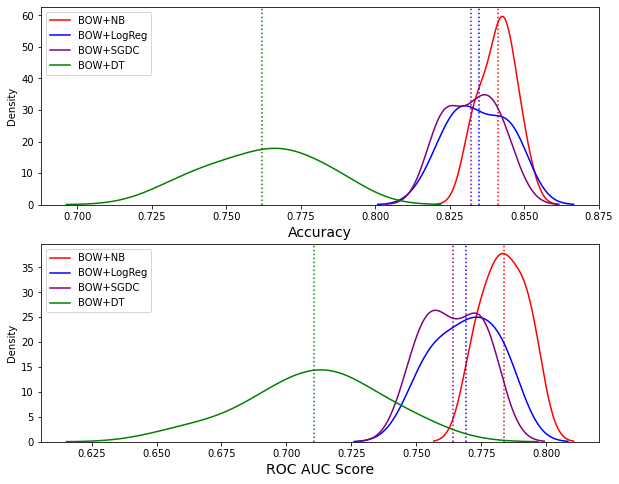

In [57]:
# List to store all models
models_bow = [bow_nb,bow_logreg,bow_sgdc,bow_dt]
colors = ['red','blue','purple','green','orange']

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

# Iterate over all models
for i,model in enumerate(models_bow):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

It looks like our baseline model, i.e. BOW+Naive Bayes performs the best out of the other models. Let's see if we can improve these scores by using another vectorizer: TF-IDF.

# 5. Vectorizer: TF-IDF

We have created our baseline model using the simple bag-of-words vectorizer. Now, we will focus on the models that have the best performance, i.e. naive bayes, logistic regression, and stochastic gradient descent. We will use the TF-IDF vectorizer to see if we can improve their performance.

### a. TF-IDF + Naive Bayes

In [58]:
# Instantiate the model
tfidf_nb = Model('TF-IDF+NB',data_clean,TfidfVectorizer(),MultinomialNB())

In [59]:
# Train on training set and evaluate prediction on test set
tfidf_nb.train_and_evaluate_base()

Accuracy score: 78.852%
ROC AUC score: 0.656


### b. TF-IDF + Logistic Regression

In [60]:
# Instantiate the model
tfidf_logreg = Model('TF-IDF+LogReg',data_clean,TfidfVectorizer(),LogisticRegression())

In [61]:
# Train on training set and evaluate prediction on test set
tfidf_logreg.train_and_evaluate_base()

Accuracy score: 84.828%
ROC AUC score: 0.787


### c. TF-IDF + Stochastic Gradient Descent

In [62]:
# Instantiate the model
tfidf_sgdc = Model('TF-IDF+SGDC',data_clean,TfidfVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [63]:
# Train on training set and evaluate prediction on test set
tfidf_sgdc.train_and_evaluate_base()

Accuracy score: 84.441%
ROC AUC score: 0.777


### d. TF-IDF + Decision Tree

In [64]:
# Instantiate the model
tfidf_dt = Model('TF-IDF+DT',data_clean,TfidfVectorizer(),DecisionTreeClassifier(random_state=42))

In [65]:
# Train on training set and evaluate prediction on test set
tfidf_dt.train_and_evaluate_base()

Accuracy score: 77.487%
ROC AUC score: 0.725


### e. TF-IDF + LGBM

In [66]:
# Instantiate the model
tfidf_lgbm = Model('TF-IDF+LGBM',data_clean,TfidfVectorizer(),LGBMClassifier(random_state=42))

In [67]:
# Train on training set and evaluate prediction on test set
tfidf_lgbm.train_and_evaluate_base()

Accuracy score: 83.904%
ROC AUC score: 0.778


### Compare the models

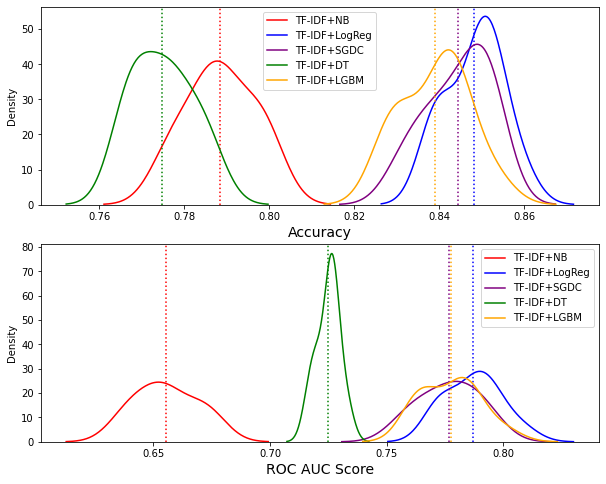

In [68]:
# List to store all models
models_bow = [tfidf_nb,tfidf_logreg,tfidf_sgdc,tfidf_dt,tfidf_lgbm]

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_bow):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

Using TF-IDF as our vectorizer, the best-performing models are the logistic regression, stochastic gradient descent, and LGBM. These models perform better than when bag-of-words vectorizer is used. Another interesting part, the naive bayes performs significantly worse when using TF-IDF.

# 6. Hyperparameter Tuning

We have established our baseline model and using TF-IDF as our text representation. Since our dataset From the results above, the most promising models are logistic regression and stochastic gradient descent. We will focus only on these three models and see if we can still improve the model performance by tuning the hyperparameters and equal sampling of the target classes.

In [69]:
# Dictionary for Bayesian search
# Vectorizer
param_vec = {
    'vec__ngram_range': hp.choice('ngram_range',[(1,1),(1,2),(1,3)]),
    'vec__max_df': hp.choice('max_df',[0.5,0.75,1.0]),
    'vec__min_df': hp.choice('min_df',[1,5,10]),
    'vec__max_features': hp.choice('max_features',[None, 500, 1000])
}

# Range of hyperparameters for the classifiers
# Classifier: naive bayes
param_nb = {
    'clf__alpha': hp.loguniform('alpha',-3,1)
}

# Classifier: Logistic Regression
param_logreg = {
    'clf__C': hp.loguniform('C',-3,1),
    'clf__penalty': hp.choice('penalty',['l2','none']),
    'clf__solver': hp.choice('solver',['newton-cg','lbfgs'])
}

# Classifier: SGDC
param_sgdc = {
    'clf__alpha': hp.choice('alpha',np.logspace(-5,0,6))
}

# Classifier: Decision Tree
param_dt = {
    'clf__criterion': hp.choice('criterion',['gini','entropy']),
    'clf__max_depth': hp.choice("max_depth_dtree", np.arange(10,50,10)),
    'clf__min_samples_leaf': hp.choice('min_samples_leaf',[5,10,20,50,100])
}

# Classifier: LGBM
param_lgbm = {
    'clf__max_depth': hp.choice('max_depth',np.arange(3,10,1)),
    'clf__num_leaves': hp.choice('num_leaves',np.arange(20,3000)),
    'clf__learning_rate': hp.uniform('learning_rate',0.05,0.2)
}

### a. TF-IDF+Naive Bayes

In [70]:
# Use bayesian search
tfidf_nb.bayes_search(space={**param_vec,**param_nb})

100%|██████████| 50/50 [03:09<00:00,  3.79s/trial, best loss: 0.15388098374408232]


In [71]:
# Print the best hyperparameters
tfidf_nb.best_params_hp

{'clf__alpha': 0.05282287714412626,
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 3)}

In [72]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_nb.train_and_evaluate_hp()

Accuracy score: 84.727%
ROC AUC score: 0.788


### b. TF-IDF + Logistic Regression

In [73]:
# Use bayesian search
tfidf_logreg.bayes_search(space={**param_vec,**param_logreg})

100%|██████████| 50/50 [08:24<00:00, 10.09s/trial, best loss: 0.14640508144193165]


In [74]:
# Print the best hyperparameters
tfidf_logreg.best_params_hp

{'clf__C': 2.157987368910842,
 'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'vec__max_df': 0.5,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [75]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_logreg.train_and_evaluate_hp()

Accuracy score: 85.465%
ROC AUC score: 0.802


### c. TF-IDF + Stochastic Gradient Descent

In [76]:
# Use bayesian search
tfidf_sgdc.bayes_search(space={**param_vec,**param_sgdc})

100%|██████████| 50/50 [02:54<00:00,  3.48s/trial, best loss: 0.14906428834001528]


In [77]:
# Print the best hyperparameters
tfidf_sgdc.best_params_hp

{'clf__alpha': 1e-05,
 'vec__max_df': 0.5,
 'vec__max_features': None,
 'vec__min_df': 5,
 'vec__ngram_range': (1, 3)}

In [78]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_sgdc.train_and_evaluate_hp()

Accuracy score: 84.978%
ROC AUC score: 0.803


### d. TF-IDF + Decision Tree

In [79]:
# Use bayesian search
tfidf_dt.bayes_search(space={**param_vec,**param_dt})

100%|██████████| 50/50 [03:31<00:00,  4.24s/trial, best loss: 0.21002500474761732]


In [80]:
# Print the best hyperparameters
tfidf_dt.best_params_hp

{'clf__criterion': 'entropy',
 'clf__max_depth': 40,
 'clf__min_samples_leaf': 20,
 'vec__max_df': 1.0,
 'vec__max_features': 500,
 'vec__min_df': 10,
 'vec__ngram_range': (1, 1)}

In [81]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_dt.train_and_evaluate_hp()

Accuracy score: 79.168%
ROC AUC score: 0.705


### e. TF-IDF + LGBM

In [82]:
# Use bayesian search
tfidf_lgbm.bayes_search(space={**param_vec,**param_lgbm})

 14%|█▍        | 7/50 [01:07<06:46,  9.45s/trial, best loss: 0.16742763202686706]

/home/mrafifrbbn/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



 64%|██████▍   | 32/50 [04:55<03:30, 11.68s/trial, best loss: 0.165220055999862]  

/home/mrafifrbbn/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



100%|██████████| 50/50 [08:30<00:00, 10.22s/trial, best loss: 0.16486890220612893]


In [83]:
# Print the best hyperparameters
tfidf_lgbm.best_params_hp

{'clf__learning_rate': 0.1665656084563607,
 'clf__max_depth': 9,
 'clf__num_leaves': 2706,
 'vec__max_df': 0.75,
 'vec__max_features': None,
 'vec__min_df': 1,
 'vec__ngram_range': (1, 2)}

In [84]:
# Evaluate model with cross-validation using the best hyperparameters
tfidf_lgbm.train_and_evaluate_hp()

Accuracy score: 83.493%
ROC AUC score: 0.766


### Compare the models

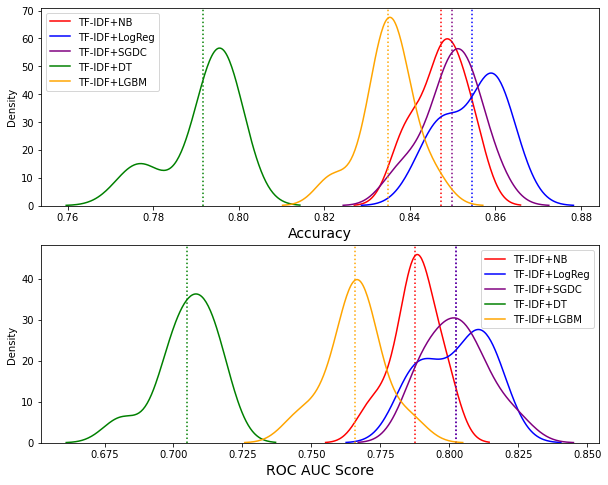

In [85]:
# List to store all models
models_best = [tfidf_nb,tfidf_logreg,tfidf_sgdc,tfidf_dt,tfidf_lgbm]

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score_hp),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

# 7. Imbalance Handling

We already know in the EDA section that our dataset is imbalanced, where the majority class, `Recommended`, is more than three times as many as the minority class, `Not Recommended`. We will now try to balance the classes and see if we can still improve our model performance. We will only use the undersampling method of the majority class, since ~4000 reviews should be plenty enough to train our model.

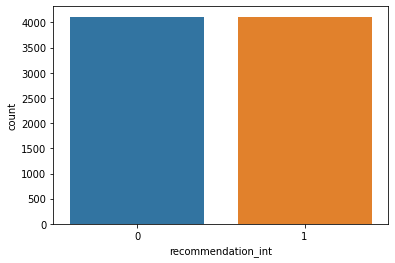

In [109]:
# Import undersampling
from imblearn.under_sampling import RandomUnderSampler

X = data_train[['review']]
y = data_train[['recommendation_int']]

# Undersampling
X_under, y_under = RandomUnderSampler(random_state=42).fit_resample(X,y)
data_under = X_under.join(y_under)

# Check count plot
sns.countplot(x='recommendation_int',data=data_under)

### a. TF-IDF + Naive Bayes

In [110]:
# Define the model
tfidf_nb_balanced = Model('TF-IDF+NB',data_under,TfidfVectorizer(),MultinomialNB())

In [111]:
# Perform bayesian search
tfidf_nb_balanced.bayes_search(space={**param_vec,**param_nb})

100%|██████████| 50/50 [01:09<00:00,  1.40s/trial, best loss: 0.1889131984326008] 


In [112]:
# Evaluate with cross validation
tfidf_nb_balanced.train_and_evaluate_hp()

Accuracy score: 81.084%
ROC AUC score: 0.811


### b. TF-IDF + Logistic Regression

In [113]:
# Define the model
tfidf_logreg_balanced = Model('TF-IDF+LogReg',data_under,TfidfVectorizer(),LogisticRegression())

In [114]:
# Perform bayesian search
tfidf_logreg_balanced.bayes_search(space={**param_vec,**param_logreg})

100%|██████████| 50/50 [02:46<00:00,  3.32s/trial, best loss: 0.1806486019345046] 


In [115]:
# Evaluate with cross validation
tfidf_logreg_balanced.train_and_evaluate_hp()

Accuracy score: 82.348%
ROC AUC score: 0.823


### c. TF-IDF + Stochastic Gradient Descent

In [116]:
# Instantiate the model
tfidf_sgdc_balanced = Model('TF-IDF+SGDC',data_under,TfidfVectorizer(),SGDClassifier(loss='log_loss',random_state=42))

In [117]:
# Perform bayesian search
tfidf_sgdc_balanced.bayes_search(space={**param_vec,**param_sgdc})

100%|██████████| 50/50 [01:18<00:00,  1.56s/trial, best loss: 0.18125650467006693]


In [118]:
# Evaluate with cross validation
tfidf_sgdc_balanced.train_and_evaluate_hp()

Accuracy score: 82.239%
ROC AUC score: 0.822


### d. TF-IDF + Decision Tree

In [119]:
# Instantiate the model
tfidf_dt_balanced = Model('TF-IDF+DT',data_under,TfidfVectorizer(),DecisionTreeClassifier(random_state=42))

In [120]:
# Perform bayesian search
tfidf_dt_balanced.bayes_search(space={**param_vec,**param_dt})

100%|██████████| 50/50 [01:21<00:00,  1.64s/trial, best loss: 0.27486222471719224]


In [121]:
# Evaluate with cross validation
tfidf_dt_balanced.train_and_evaluate_hp()

Accuracy score: 72.247%
ROC AUC score: 0.722


### e. TF-IDF + LGBM

In [122]:
# Instantiate the model
tfidf_lgbm_balanced = Model('TF-IDF+LGBM',data_under,TfidfVectorizer(),LGBMClassifier(random_state=42))

In [123]:
# Perform bayesian search
tfidf_lgbm_balanced.bayes_search(space={**param_vec,**param_lgbm})

100%|██████████| 50/50 [02:54<00:00,  3.48s/trial, best loss: 0.20192202151665462]


In [124]:
# Evaluate with cross validation
tfidf_lgbm_balanced.train_and_evaluate_hp()

Accuracy score: 79.613%
ROC AUC score: 0.796


### Compare the models

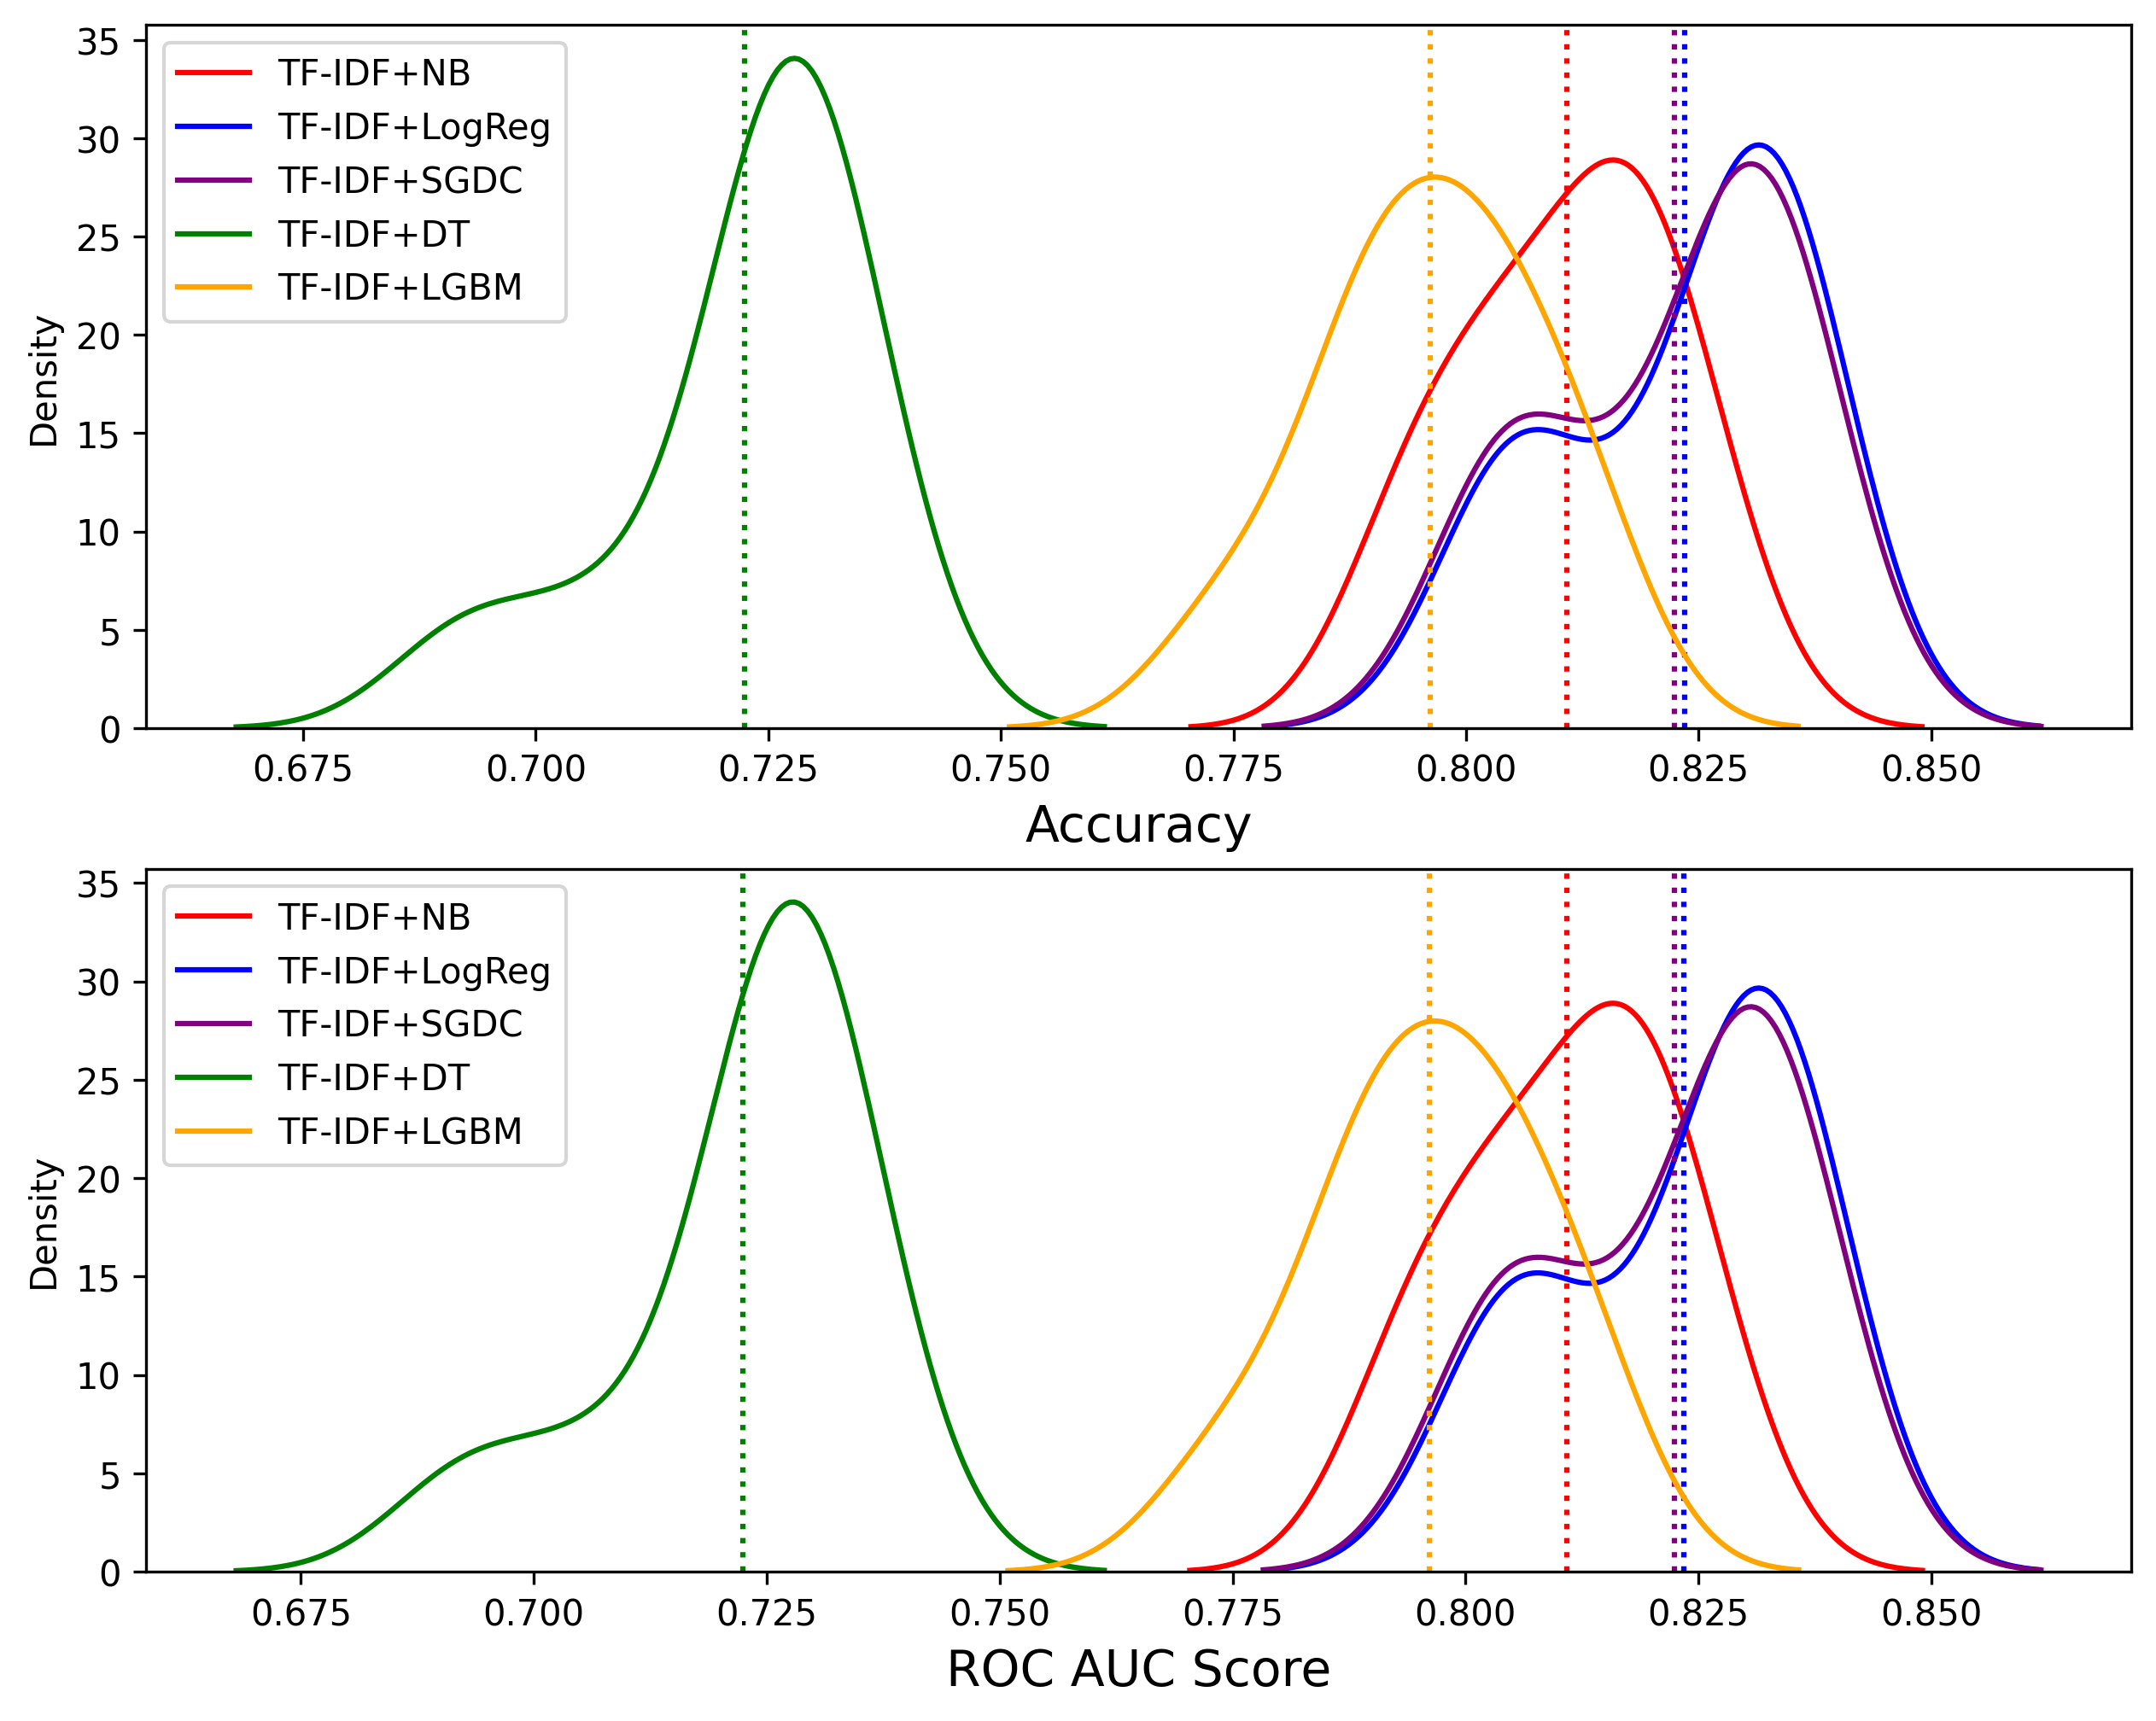

In [131]:
# List to store all models
models_best = [tfidf_nb_balanced,tfidf_logreg_balanced,tfidf_sgdc_balanced,tfidf_dt_balanced,tfidf_lgbm_balanced]
colors = ['red','blue','purple','green','orange']

# Plot histogram of roc accuracy score
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,8))

for i,model in enumerate(models_best):
    
    # Plot accuracy
    sns.kdeplot(model.cv_accuracy_score_hp,ax=ax1,color=colors[i],label=model.name)
    ax1.axvline(x=np.mean(model.cv_accuracy_score_hp),color=colors[i],ls=':')
    
    ax1.legend()
    ax1.set_xlabel('Accuracy',fontsize=14)
    
    # Plot ROC AUC score
    sns.kdeplot(model.cv_roc_auc_score_hp,ax=ax2,label=model.name,color=colors[i])
    ax2.axvline(x=np.mean(model.cv_roc_auc_score_hp),color=colors[i],ls=':')
    
    ax2.legend()
    ax2.set_xlabel('ROC AUC Score',fontsize=14)

It looks like training our model on a balanced dataset does not improve the performance significantly. However, one advantage of balancing the dataset is that the accuracy score can now be interpreted more objectively. Based on the average score from cross-validation, the best-performing model is the TF-IDF+LogReg, which is consistent with the results obtained from the original training set, followed by TF-IDF+SGDC and TF-IDF+NB. 

Therefore, we will choose TF-IDF+LogReg with the obtained hyperparameters as our best and final model, and use it to make predictions on the test data.

# 7. Model Evaluation

In [103]:
# Make predictions on test data using baseline model
baseline_model.predict_test(data_test,False)

Model: BOW+NB 

Confusion matrix: 
 [[1181  632]
 [ 347 3820]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.65      0.71      1813
           1       0.86      0.92      0.89      4167

    accuracy                           0.84      5980
   macro avg       0.82      0.78      0.80      5980
weighted avg       0.83      0.84      0.83      5980



TN - True Positive: 3820
FP - False Negative: 347
FN - False Positive: 632
TP - True Negative: 1181
Accuracy Rate: 83.6%
Misclassification Rate: 16.400000000000002%
Recall: 0.917
Precision: 0.858
F1-Score: 0.886
ROC-AUC score: 0.784


In [104]:
# Predictions on test data using our best model
tfidf_logreg.predict_test(data_test,True)

Model: TF-IDF+LogReg 

Confusion matrix: 
 [[1537  276]
 [  69 4098]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      1813
           1       0.94      0.98      0.96      4167

    accuracy                           0.94      5980
   macro avg       0.95      0.92      0.93      5980
weighted avg       0.94      0.94      0.94      5980



TN - True Positive: 4098
FP - False Negative: 69
FN - False Positive: 276
TP - True Negative: 1537
Accuracy Rate: 94.19999999999999%
Misclassification Rate: 5.800000000000001%
Recall: 0.983
Precision: 0.937
F1-Score: 0.96
ROC-AUC score: 0.916


Whoa, it looks like our best model performs much better on the test set than during the cross-validation with the training data! This number seems too good to be true though, so it's a good idea to be skeptical about this result and test this same model on larger dataset from different sources.

Let's see what words are strongly associated with good reviews, and words that are associated with bad reviews.

### Check features

In [105]:
# Use eli5
import eli5

eli5.show_weights(tfidf_logreg.final_pipeline, vec=tfidf_logreg.final_pipeline.named_steps["vec"], top=20)

/home/mrafifrbbn/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Words with positive weights are 'great', 'best', 'amazing', etc. They seem to be mostly compliments to the games, and they are not that useful as feedback for game developers. However, some of the negative words are 'mod', 'crash', 'cheater', 'hacker', and 'lag'. Among the top games in this dataset are PUBG and Rust, which are both FPS games. And as someone who plays FPS game, these problems are also commonly found in other FPS games I have played, which made my gaming experience not pleasant. So it looks like our model has captured the most important problems from the opinions of the reviewers.

Let's plot the ROC and precision-recall curve to see how our model has improved the baseline model.

### Plot ROC curve

In [106]:
# Function to plot ROC curve
def plot_roc(models,colors,labels):
    # Define figure object
    plt.figure(figsize=(6,6))
    
    for i, model in enumerate(models):
        model.get_roc(color=colors[i],label=labels[i])

    # Extra touch
    plt.plot([0.,1.],[0.,1.],color='k',ls='--',label='random classifier')
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title('ROC curve',fontsize=14)
    plt.xlim(0.,1.)
    plt.ylim(0.,1.)
    plt.legend(loc='lower right')
    plt.show()
    return

# Function to plot precision-recall curve
def plot_prc(models,colors,labels):
    # Define figure object
    plt.figure(figsize=(6,6))
    
    for i, model in enumerate(models):
        model.get_prc(color=colors[i],label=labels[i])

    # Extra touch
    plt.axhline(y=models[0].y_noskill,color='k',ls='--',label='random classifier')
    plt.xlabel('Recall',fontsize=14)
    plt.ylabel('Precision',fontsize=14)
    plt.title('Precision-recall curve',fontsize=14)
    plt.xlim(0.,1.)
    plt.legend(loc='center left')
    plt.show()
    return

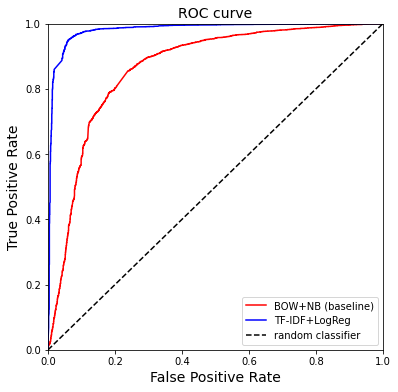

In [107]:
models_best = [baseline_model,tfidf_logreg]
colors = ['red','blue']
labels = ['BOW+NB (baseline)','TF-IDF+LogReg']

plot_roc(models_best,colors,labels)

### Plot precision-recall curve

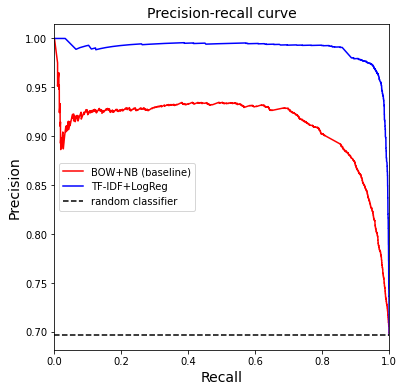

In [108]:
plot_prc(models_best,colors,labels)

# Conclusions:

1. We have analyzed a subset of the Steam Games Reviews dataset from Kaggle.
2. Most of the reviews are positive, with frequent words such as 'awesome', 'fun', and 'love'. While the negative reviews are filled with words such as 'cheater', 'bug', and 'hacker'.
3. We have applied standard text cleaning to clean the reviews: removing punctuations, digits, stop words, and stemming.
4. We set our baseline model as BOW + Naive Bayes, as it is commonly used in text classification such as spam detection. After trying out models using TF-IDF as the vectorizer and employing hyperparameter tuning using the Bayesian search, our best model is the TF-IDF+logistic regression (TF-IDF+LogReg).
5. From the cross-validation method using the test data, the TF-IDF+LogReg model yields an accuracy of 84.603% and an ROC AUC score of 0.779. These numbers increased to 85.465% for accuracy and 0.802 for ROC AUC.
6. We find that training the model on a balanced training set using undersampling method does not improve the performance significantly.
7. The baseline model, which we take to be BOW+NB, yields an accuracy of 83.6% and an ROC AUC score of 0.784 on the test data. Whereas the TF-IDF+LogReg yields an accuracy of 94.2% and an ROC AUC score of 0.916 on the test data, and so we have built a model with a much better performance than our baseline model. This accuracy seems to be too high, and so it may be better to immediately test it on a new, unseen dataset from a different source.